In [ ]:
from io import BytesIO

import pandas as pd
import numpy as np
import panel as pn
pn.extension('tabulator')
import matplotlib.pyplot as plt
import hvplot.pandas
import matplotlib.gridspec as gridspec


In [ ]:
def get_number_of_rows(dataframe):
    df = pd.read_csv(dataframe)
    return df.shape[0]

In [ ]:
import os
path = '../data'
files = os.listdir(path)
path_files = [path + '/'+ string for string in files]
number_of_rows = [get_number_of_rows(dataframe) for dataframe in path_files]
#dict_values = [(file_name, n_rows) for file_name, n_rows in zip(path_files, number_of_rows) ]
file_entries = dict(zip(files,path_files))
file_rows = dict(zip(path_files,number_of_rows))


In [ ]:
file_rows

In [ ]:
def iqr(array):
    q3, q1 = np.percentile(array,[75,25])
    IQR = q3 - q1
    upper_bound = q3 + 1.5*IQR
    lower_bound = q1 - 1.5*IQR
    return lower_bound, upper_bound

In [ ]:
select = pn.widgets.Select(options=file_entries)

@pn.cache
def fetch_data(url):
    df = pd.read_csv(url)
    df.drop('time', axis = 1, inplace = True)
    df.insert(0,'time',df.index.values)
    df = df.fillna(0)
    for column in df.keys():
        lower_bound, upper_bound =iqr(df[column].to_numpy())
        df = df[df[column] > lower_bound ]
        df = df[df[column] < upper_bound ]


    return df

select_df = pn.Column(select, pn.bind(pn.widgets.Tabulator, pn.bind(fetch_data, select), page_size=10))

In [ ]:
@pn.cache
def plot(df = None, cols = None, last = None, n = 2):
    df = fetch_data(df)
    breakpoint()
    time = df.time.to_numpy()
    fig = plt.figure(tight_layout=True)
    gs = gridspec.GridSpec(n, n)
    if last is not None:
        ax = fig.add_subplot(gs[1, :])
        ax.plot(time, df[last])
        ax.set_ylabel(last)
        ax.set_xlabel('time')
    for i in range(n):
        ax = fig.add_subplot(gs[0, i])
        ax.plot(time, df[cols[i]])
        ax.set_ylabel(cols[i])
        ax.set_xlabel('time')
    return fig

KeyError: 's'

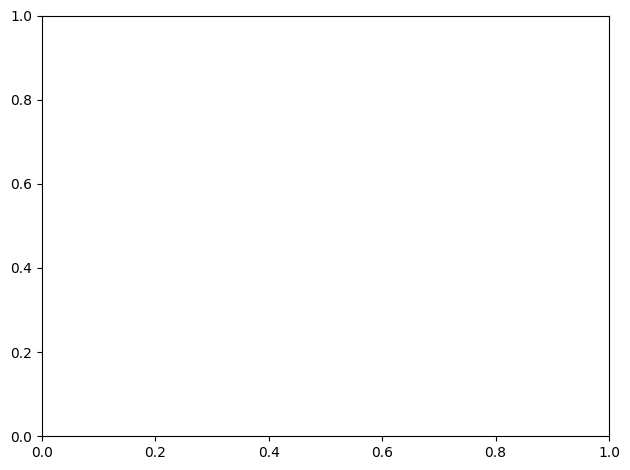

In [13]:
figure = pn.bind(plot, select, 'shoulderLangle',None, 1)
pn.Tabs('Bla',figure)

In [ ]:
body_parts = ("shoulder","elbow","knee","wrist","hip","ankle")

In [ ]:
tab_0 = pn.Tabs()
for part in body_parts:
    fig_0 = pn.bind(plot, select,("".join(("l","_",part,"X")),"".join(("l","_",part,"Y"))),"".join(("l","_",part,"Z")),2)
    tab_0.append((part, fig_0))
    tab_0.append((part, fig_1))
    

In [ ]:
tab_1 = pn.Tabs()
for part in body_parts:
    fig_0 = pn.bind(plot, select,("".join(("l","_",part,"X")),"".join(("l","_",part,"Y"))),"".join(("l","_",part,"Z")),2)
    tab_0.append((part, fig_0))
    

## Tabs

## Create the Template

In [ ]:
#Layout using Template
template = pn.template.BootstrapTemplate(
    title='Data analysis for motor disabilities rehabilitation of the upper limbs using augmented reality', 
    sidebar=[pn.pane.Markdown(""), 
             pn.pane.Markdown("#### Choose the dataframe"), 
             select_df,
            ],
    main= [pn.Row(tab_0, tab_0)],
    accent_base_color="#87d8b1",
    header_background="#8508b0",
)
template.show()
template.servable();